## Market1501 / cuhk03 

{'UMPM': {'password': 'ahJaka4o', 'username': 'umpmuser'},
 'data_root': '/storage/DATA/pak'}



/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


/storage/DATA/pak/cuhk03_release found :)
/storage/DATA/pak/Market-1501-v15.09.15 found :)
/storage/DATA/pak/DukeMTMC-reID found :)
found memmaped /storage/DATA/pak/cuhk03_release/labeled64x64.npy
(cuhk) positive test pairs: 9290
(cuhk) positive train pairs: 127242
(market) positive test pairs:  300631
(market) positive train pairs:  309874
load memmap /storage/DATA/pak/DukeMTMC-reID/bounding_box_test64x64.npy
load memmap /storage/DATA/pak/DukeMTMC-reID/bounding_box_train64x64.npy
(duke) positive test pairs:  926089
(duke) positive train pairs:  749270
is same: [1 0]


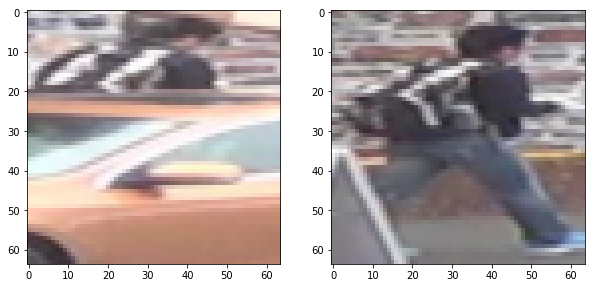

In [1]:
%matplotlib inline
import json
from pprint import pprint
Settings = json.load(open('settings.txt'))
pprint(Settings)
print('')
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../')
from reid.stacknet import get_model
from reid.data import DataSampler

from keras.callbacks import ModelCheckpoint, TerminateOnNaN
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input
from os.path import join, isfile, isdir, exists, splitext

root = Settings['data_root']

sampler = DataSampler(root, 64, 64)

x, y = sampler.get_test_batch(5, 5)

pid = 3
print('is same:', y[pid])
im = x[pid]
fig = plt.figure(figsize=(10, 6))
fig.add_subplot(121).imshow(im[:,:,0:3])
fig.add_subplot(122).imshow(im[:,:,3:6])
plt.show()

## UMPM dataset

/storage/DATA/pak
UMPM
elapsed 1.0138142108917236
same [0 1]
(32, 64, 64, 6)


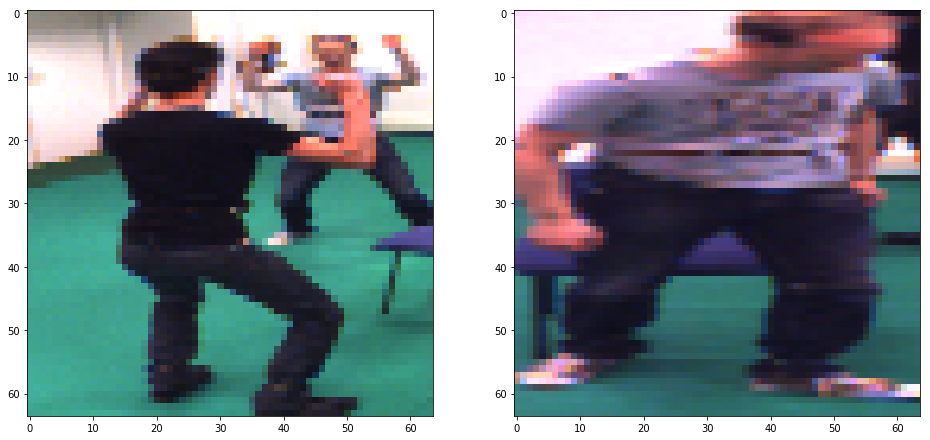

In [7]:
from time import time
from reid.data import UMPMSampler

root = Settings['data_root']
print(root)

user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']
umpm_sampler = UMPMSampler(root, ['p2_chair_2'], user, pwd, 64, 64)


_start = time()
x, y = umpm_sampler.get_train()
_end = time()
print('elapsed', _end - _start)

print('same', y[0])

print(x.shape)

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
ax.imshow(x[0, :, :, 0:3].astype('uint8'))
ax = fig.add_subplot(122)
ax.imshow(x[0, :, :, 3:6].astype('uint8'))
plt.show()

## MOT16 dataset

/storage/DATA/pak/MOT16 found :)
MOT16: load memmapped file /storage/DATA/pak/MOT16/train/MOT16-02/data.memmap
MOT16 X loaded
MOT16 Y_det loaded
MOT16 Y_gt loaded
(MOT16) total number of bounding boxes: 1736
elapsed 0.3611476421356201
same [0 1]


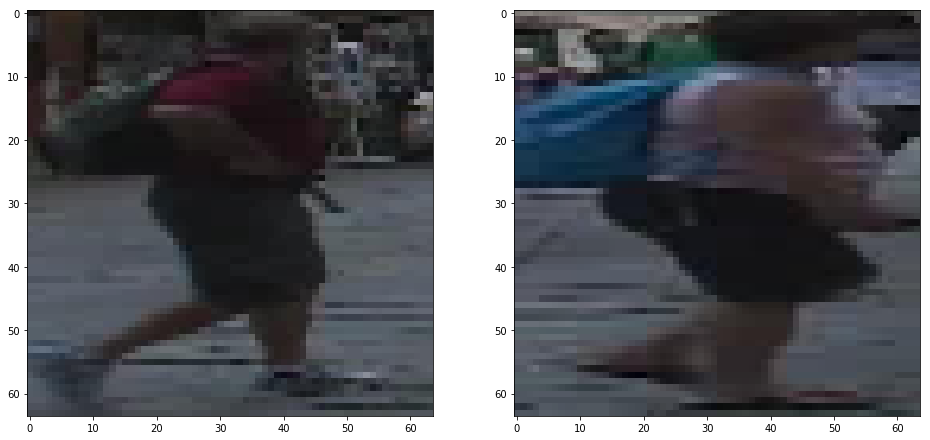

In [3]:
from reid.data import MOT16Sampler

mot_sampler = MOT16Sampler(root, 64, 64)


_start = time()
x, y = mot_sampler.sample()
_end = time()
print('elapsed', _end - _start)

print('same', y[0])

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
ax.imshow(x[0,:,:,0:3].astype('uint8'))
ax = fig.add_subplot(122)
ax.imshow(x[0,:,:,3:6].astype('uint8'))
plt.show()

## Training

In [4]:
from keras.callbacks import ModelCheckpoint, TerminateOnNaN
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input

filepath = join('data_storage', 'model.h5')

checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint, TerminateOnNaN()]

if isfile(filepath):
    model = load_model(filepath)
else:
    model = get_model()

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        3520      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 16, 16, 256)       295168    
__________

In [5]:
# def generate_training_data():
#     global sampler
#     while True:
#         X, Y = sampler.get_train_batch(16, 16)
#         X = preprocess_input(X.astype('float64'))
#         yield X, Y

# def generate_validation_data():
#     global sampler
#     while True:
#         X, Y = sampler.get_test_batch(16, 16)
#         X = preprocess_input(X.astype('float64'))
#         yield X, Y

# history = model.fit_generator(generate_training_data(),
#                     validation_data=generate_validation_data(),
#                     validation_steps=5,
#                     steps_per_epoch=100,
#                     epochs=1000,
#                     callbacks=callbacks_list)